In [2]:
#! /usr/bin/env python
# general
import os
from os.path import join
import sys
from pathlib import Path
import math
import copy
import time
import glob

# ml
import torch
import torch.backends.cudnn as cudnn

# Plot
from matplotlib import pyplot as plt
import numpy as np

# cv
import cv2
import scipy.ndimage as ndimage
# from cv_bridge import CvBridge, CvBridgeError

# yolov5 imports
from models.common import DetectMultiBackend
from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
from utils.plots import Annotator, colors, save_one_roi
from utils.torch_utils import select_device, time_sync


# ggcnnv2 imports
from ggcnn.models import ggcnn2
from ggcnn.utils.dataset_processing import grasp, image, evaluation1
from ggcnn.utils.dataset_processing.grasp import GraspRectangle
from ggcnn.models.common import post_process_output
from ggcnn.utils.timeit import TimeIt

# agnostic
from agnostic_segmentation import agnostic_segmentation
from agnostic_segmentation import compute_grasp

topicmanager initialized


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [57]:
ROOT = '/home/felipe/code/APC/grasping/'
source=ROOT+'content/datasets/cornell_v2/test/images/pcd0313r_png.rf.8933460d094ee0d8392cd86f11adcca3.jpg'
model_path = '/home/felipe/code/APC/grasping/models/FAT_trained_Ml2R_bin_fine_tuned.pth'
rgb_img = cv2.imread(source)
predictions = agnostic_segmentation.segment_image(rgb_img, model_path)
boxes = predictions['instances'].pred_boxes.tensor
boxes_np = boxes.cpu().detach().numpy().astype(int)
masks = predictions['instances'].pred_masks
seg_img = agnostic_segmentation.draw_segmented_image(rgb_img, predictions)
print(boxes_np)

[Checkpointer] Loading from /home/felipe/code/APC/grasping/models/FAT_trained_Ml2R_bin_fine_tuned.pth ...


[[297 212 364 320]]


[267 190 400 352]


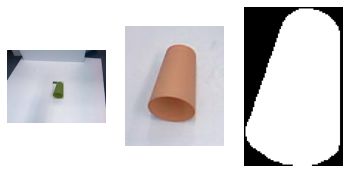

In [58]:
%matplotlib inline
zoom_p = 0.1
roi = (boxes_np[0]*np.array([1-zoom_p, 1-zoom_p, 1+zoom_p, 1+zoom_p])).astype(int)
print(roi)
plt.subplot(1,3,1)
plt.imshow(seg_img)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(cv2.imread(source)[roi[1]:roi[3], roi[0]:roi[2]])
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(masks[0].cpu().detach().numpy()[boxes_np[0][1]:boxes_np[0][3],boxes_np[0][0]:boxes_np[0][2]], cmap='gray')
plt.axis('off')
plt.show()

480 640


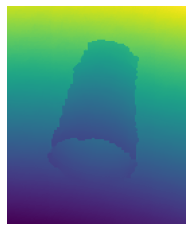

In [60]:
###################################################################################################
# GGCNN
###################################################################################################
device2 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
crop_size = 300
out_size = crop_size
y_off = 0
x_off = 0
MODEL_FILE = 'ggcnn/ggcnn2_093'
model2 = torch.load(MODEL_FILE, map_location=device2)

# Carga la imagen RGB -> El metodo ya esta definido en utils.dataset_processing import image
rgb_img = image.Image.from_file('/home/felipe/code/APC/ggcnn/datasets/cornell/03/pcd0313r.png')

# Carga la imagen de profundidad -> El metodo ya esta definido en utils.dataset_processing import image DepthImage
# Se puede cargar desde el tiff
depth_img = image.DepthImage.from_tiff('/home/felipe/code/APC/ggcnn/datasets/cornell/03/pcd0313d.tiff')
# Se puede cargar desde el pcd
depth_img_pcd = image.DepthImage.from_pcd('/home/felipe/code/APC/ggcnn/datasets/cornell/03/pcd0313.txt',depth_img.__getattr__('shape'))

# La funcion de __getattr__ permite traer propiedades del objeto imagen
imh, imw = depth_img.__getattr__('shape')
print(imh, imw)

# depth_crop tiene que ser un array 
depth_crop = np.asarray(depth_img)
depth_crop2 = np.asarray(depth_img)
# The ROI region is crop to the depth image
depth_crop = depth_crop[roi[1]:roi[3], roi[0]:roi[2]]
%matplotlib inline
plt.imshow(depth_crop)
plt.axis('off')
plt.show()

In [61]:
# Agrega un borde de un pixel a la imagen - para aplicar filtros
# Crea una mascara verificando si hay nan (en general dara ceros)
with TimeIt('1'):
    depth_crop = cv2.copyMakeBorder(depth_crop, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
    depth_nan_mask = np.isnan(depth_crop).astype(np.uint8)
depth_crop[0,0]
print(depth_crop.shape)
print(depth_nan_mask.shape)
# Si encuentra algun valor que sea nan lo vuelve cero 
with TimeIt('2'):
    depth_crop[depth_nan_mask==1] = 0
# Normalizacion
with TimeIt('3'):
    # Scale to keep as float, but has to be in bounds -1:1 to keep opencv happy.
    depth_scale = np.abs(depth_crop).max()
    depth_crop = depth_crop.astype(np.float32) / depth_scale 
# Elimina trazos u otras imperfecciones
# with TimeIt('Inpainting'):
    # depth_crop = cv2.inpaint(depth_crop, depth_nan_mask, 1, cv2.INPAINT_NS)
# Restaura dimensiones y valores
depth_crop = depth_crop[1:-1, 1:-1] # quita el borde de 1 pixel
depth_crop = depth_crop * depth_scale
# Normaliza valores con el promedio en el rango [-1 1]
depth = depth_crop
depth = np.clip((depth - depth.mean()), -1, 1)
depthn = depth.copy()
# Convierte la imagen de profundidad a un tensor para usar en torch
depthT = torch.from_numpy(depth.reshape(1, 1, depth.shape[0], depth.shape[1]).astype(np.float32)).to(device2)

1: 0.2ms
(164, 135)
(164, 135)
2: 0.0ms
3: 0.2ms


/tmp/ipykernel_9003/541446558.py:13: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  points_out = ndimage.filters.gaussian_filter(points_out, filters[0])  # 3.0
/tmp/ipykernel_9003/541446558.py:14: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  ang_out = ndimage.filters.gaussian_filter(ang_out, filters[1])
/tmp/ipykernel_9003/541446558.py:15: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  width_out = ndimage.filters.gaussian_filter(width_out, filters[2])


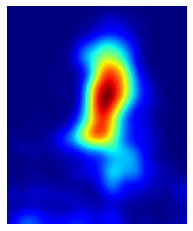

In [62]:
# no_grad se utiliza para validaciones, acelera calculos y reduce memoria
with torch.no_grad():
    # Se realiza la prediccion de la red
    pred_out = model2(depthT)
# Convierte el tensor de pythorch a un array de np, eliminando los ejes 1,1
points_out = pred_out[0].cpu().numpy().squeeze()
cos_out = pred_out[1].cpu().numpy().squeeze()
sin_out = pred_out[2].cpu().numpy().squeeze()
ang_out = np.arctan2(sin_out, cos_out) / 2.0

width_out = pred_out[3].cpu().numpy().squeeze() * 70.0  # Scaled 0-150:0-1
filters=(5.0, 4.0, 2.0)
points_out = ndimage.filters.gaussian_filter(points_out, filters[0])  # 3.0
ang_out = ndimage.filters.gaussian_filter(ang_out, filters[1])
width_out = ndimage.filters.gaussian_filter(width_out, filters[2])
points_out = np.clip(points_out, 0.0, 1.0-1e-3)
%matplotlib inline
plt.imshow(points_out,cmap='jet')
plt.axis('off')
plt.show()

In [63]:
grasps = grasp.detect_grasps(points_out, ang_out, 0.5, width_img=width_out, no_grasps=10)
# maxgrasps = evaluation1.plot_output(width_out, depth, points_out, ang_out, grasps, depth_crop2, crop_size, y_off, x_off)
grasps_info = evaluation1.grasp_info(width_out, points_out, ang_out, grasps)
for g in grasps_info:
    print(g)


len 1
localn [[         66          72]]
{'q': 0.8460649, 'pix': [66, 72], 'ang': -1.055291120636827, 'width': 38.200077}


In [55]:
def draw_angled_rec(x0, y0, width, height, angle, color, img):
    _angle = angle * math.pi / 180.0
    b = math.cos(_angle) * 0.5
    a = math.sin(_angle) * 0.5
    pt0 = (int(x0 - a * height - b * width),
           int(y0 + b * height - a * width))
    pt1 = (int(x0 + a * height - b * width),
           int(y0 - b * height - a * width))
    pt2 = (int(2 * x0 - pt0[0]), int(2 * y0 - pt0[1]))
    pt3 = (int(2 * x0 - pt1[0]), int(2 * y0 - pt1[1]))

    cv2.line(img, pt0, pt1, (), 1)
    cv2.line(img, pt1, pt2, color, 1)
    cv2.line(img, pt2, pt3, color, 1)
    cv2.line(img, pt3, pt0, color, 1)
    plt.imshow(img)
    plt.show()

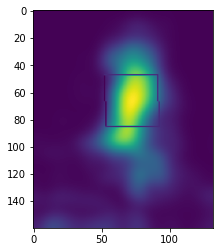

In [64]:
test = points_out.copy()
for g in grasps_info:
    draw_angled_rec(g['pix'][1],g['pix'][0],g['width'],g['width'],g['ang'],(0.1,0.1,0),test)